In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from ripser import ripser
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

C:\Users\User\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


YF.download() has changed argument auto_adjust default to True
Baseline Acc: 0.571 ± 0.014
TDA Acc:      0.583 ± 0.020
Acc p-value:  0.038
Baseline AUC: 0.594 ± 0.016
TDA AUC:      0.610 ± 0.020
AUC p-value:  0.024


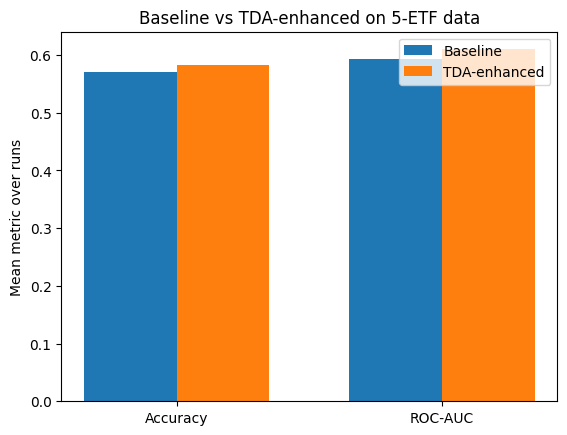

In [2]:
tickers = ['SPY','QQQ','IWM','XLF','XLK']
df = yf.download(tickers, start='2018-01-01', end='2025-05-01', progress=False)['Close'].dropna()
rets = df.pct_change().dropna()
vol_med = np.median(np.abs(rets['SPY']))
window_size = 90
horizon    = 1
n_windows  = len(rets) - window_size - horizon + 1

X, y = [], []
for i in range(n_windows):
    win = rets.iloc[i:i+window_size].values
    fut = rets['SPY'].iloc[i+window_size]
    y.append(int(abs(fut) > vol_med))
    tech = [win.mean(), win.std()]
    dgms = ripser(win, maxdim=1)['dgms']
    tda_feats = []
    for dgm in dgms:
        ls = dgm[:,1] - dgm[:,0]
        if not np.all(np.isfinite(ls)):
            finite = ls[np.isfinite(ls)]
            ls = np.where(np.isfinite(ls), ls, finite.max() if finite.size else 0)
        top3 = np.sort(ls)[::-1][:3]
        tda_feats.extend(top3)
    X.append(tech + tda_feats)
    
X = np.array(X)
y = np.array(y)
runs = 10
acc_base, acc_tda = [], []
auc_base, auc_tda = [], []

for seed in range(runs):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
    # Baseline
    clf_b = RandomForestClassifier(random_state=seed)
    clf_b.fit(X_tr[:, :2], y_tr)
    p_b = clf_b.predict_proba(X_te[:, :2])[:,1]
    acc_base.append(accuracy_score(y_te, clf_b.predict(X_te[:, :2])))
    auc_base.append(roc_auc_score(y_te, p_b))
    # Baseline with TDA
    clf_t = RandomForestClassifier(random_state=seed)
    clf_t.fit(X_tr, y_tr)
    p_t = clf_t.predict_proba(X_te)[:,1]
    acc_tda.append(accuracy_score(y_te, clf_t.predict(X_te)))
    auc_tda.append(roc_auc_score(y_te, p_t))

t_acc, p_acc = ttest_rel(acc_tda, acc_base)
t_auc, p_auc = ttest_rel(auc_tda, auc_base)

print(f"Baseline Acc: {np.mean(acc_base):.3f} ± {np.std(acc_base):.3f}")
print(f"TDA Acc:      {np.mean(acc_tda):.3f} ± {np.std(acc_tda):.3f}")
print(f"Acc p-value:  {p_acc:.3f}")
print(f"Baseline AUC: {np.mean(auc_base):.3f} ± {np.std(auc_base):.3f}")
print(f"TDA AUC:      {np.mean(auc_tda):.3f} ± {np.std(auc_tda):.3f}")
print(f"AUC p-value:  {p_auc:.3f}")

labels = ['Accuracy','ROC-AUC']
base_means = [np.mean(acc_base), np.mean(auc_base)]
tda_means  = [np.mean(acc_tda), np.mean(auc_tda)]

x = np.arange(len(labels))
w = 0.35
plt.bar(x-w/2, base_means, w, label='Baseline')
plt.bar(x+w/2, tda_means,  w, label='TDA-enhanced')
plt.xticks(x, labels)
plt.ylabel('Mean metric over runs')
plt.title('Baseline vs TDA-enhanced on 5-ETF data')
plt.legend()
plt.show()